# Day 8

## part 1

- connect junction boxes together that are as close as possible (straight line distance)
- repeat this until all junction boxes are connected in some fashion(skipping already connected boxes)
- there may be multiple circuits
- the solution is the product of the size of the circuits
- do this for the first 1000 shortest connections


In [522]:
from copy import deepcopy
from dataclasses import dataclass
import logging
from pathlib import Path

from tqdm import tqdm
from matplotlib import pyplot as plt

from advent_of_code_utils.advent_of_code_utils import (
    parse_from_file,
    ParseConfig as PC,
    markdown,
    plot_str_grid,
)

log = logging.getLogger("advent")
logging.basicConfig(level=logging.INFO)

In [523]:
# ok so this should be fairly simple once we have the infrastructure in place

@dataclass
class P3:
    x: int
    y: int
    z: int

    def parser(xyz_string: str) -> "P3":
        "for loading in from puzzle input"
        return P3(*[int(v) for v in xyz_string.split(",")])
    
    def __neg__(self) -> "P3":
        return P3(-self.x, -self.y, -self.z)

    def __add__(self, other: "P3") -> "P3":
        return P3(
            self.x + other.x,
            self.y + other.y,
            self.z + other.z,
        )

    def __sub__(self, other: "P3") -> "P3":
        return (self + (-other))
    
    def mag(self) -> "P3":
        return (self.x ** 2 + self.y ** 2 + self.z ** 2) ** 0.5

    def __eq__(self, other: "P3") -> bool:
        return (
            self.x == other.x and
            self.y == other.y and
            self.z == self.z
        )

    def __hash__(self) -> int:
        return hash((self.x, self.y, self.z))

a = P3(1, 1, 1)
b = P3(2, 3, 4)
print(a + b)
print(a - b)
print(a.mag())
print(3 ** (1/2))

P3(x=3, y=4, z=5)
P3(x=-1, y=-2, z=-3)
1.7320508075688772
1.7320508075688772


In [524]:
parser = PC("\n", P3.parser)
filepath = Path("day_8.txt")
points = parse_from_file(filepath, parser)

INFO:advent_of_code_utils.py:1000 items loaded from "day_8.txt"


Text(0.5, 1.0, 'From the top...')

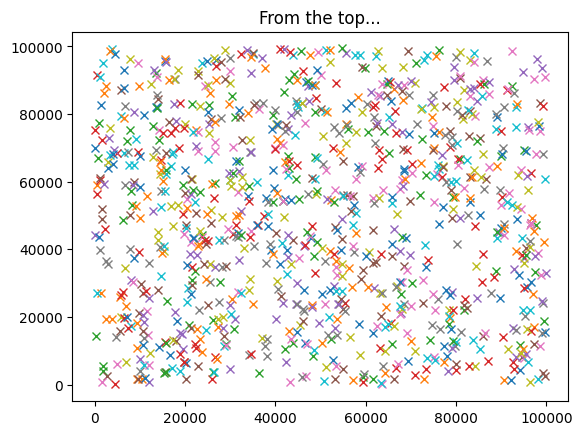

In [525]:
fig, ax = plt.subplots()
for point in points:
    ax.plot(
        point.x, point.y, marker="x", linestyle=" "
    )
ax.set_title("From the top...")

In [526]:
# first lets find each point's distance to it's nearest neighbours
r_limit = 20e3

neighbours = {}
for point in tqdm(points, desc=f"finding neighbours (<{r_limit})"):
    neighbours.update({point: list()})
    for other in points:
        # skip this point
        if other == point:
            continue
        # skip points too far away
        elif (other - point).mag() > r_limit:
            continue
        
        # else add the other point
        neighbours[point].append(other)

finding neighbours (<20000.0): 100%|██████████| 1000/1000 [00:03<00:00, 286.98it/s]


In [527]:
connections = 0
circuits = []
conn_limit = 1000
log.setLevel(logging.WARNING)
if "example" in filepath.name:
    conn_limit = 10
    log.setLevel(logging.INFO)

while True:
    # go through each set of neighbours and the minimum distance
    closest_pair = None
    pair_dist = None
    for point, others in neighbours.items():
        for other in others:
            distance = (point - other).mag()
            if pair_dist is None:
                closest_pair = point, other
                pair_dist = distance
            elif distance < pair_dist:
                closest_pair = point, other
                pair_dist = distance
    
    # now check whether either is in a circuit
    point, other = closest_pair
    # then remove them from each other's lists to avoid re-picking
    if other in neighbours[point]:
        neighbours[point].remove(other)
    if point in neighbours[other]:
        neighbours[other].remove(point)


    for circuit_p in circuits:
        if point in circuit_p:
            break
    else:
        circuit_p = None
    
    for circuit_o in circuits:
        if other in circuit_o:
            break
    else:
        circuit_o = None
    
    log.info(f"{point} {other}")
    # neither are in a circuit - create new
    if circuit_p is None and circuit_o is None:
        circuits.append([point, other])
        log.info("neither in circuits")
    # only point is in a circuit  - add other
    elif circuit_o is None:
        circuit_p.append(other)
        log.info("point in circuit")
    # only other is in a circuit - add point
    elif circuit_p is None:
        circuit_o.append(point)
        log.info("other in circuit")
    # both are in separate circuits - merge circuits
    elif circuit_p != circuit_o:
        circuits.remove(circuit_p)
        circuit_o.extend(circuit_p)
        log.info("point and other in different circuits")
    # both are in the same circuit - pass
    elif circuit_p == circuit_o:
        # log.info(f"{point=}, {other=}")
        # log.info(f"{circuit_p}, {circuit_o}")
        log.info("both circuits the same")
        pass
    else:
        raise ValueError()

    connections += 1
    print(f"{connections=}/{conn_limit}", end="\r")
    log.info(f"{[len(c) for c in circuits]}")
    if connections == conn_limit:
        break

In [528]:
top_3 = [len(c) for c in sorted(circuits, key=len, reverse=True)[:3]]
product = 1
for value in top_3:
    product *= value
markdown(f"The top 3 circuit sizes are: {top_3}")
markdown(f"- their product is: {product}")

The top 3 circuit sizes are: [53, 48, 38]

- their product is: 96672

## part 2

- continue until all junctions are in a single circuit
- the solution is the product of the two points' `x` coordinates

In [529]:
log.setLevel(logging.WARNING)
if "example" in filepath.name:
    conn_limit = 10
    log.setLevel(logging.INFO)

while True:
    # go through each set of neighbours and the minimum distance
    closest_pair = None
    pair_dist = None
    for point, others in neighbours.items():
        for other in others:
            distance = (point - other).mag()
            if pair_dist is None:
                closest_pair = point, other
                pair_dist = distance
            elif distance < pair_dist:
                closest_pair = point, other
                pair_dist = distance
    
    if closest_pair is None:
        log.warning("ran out of pairs")
        break
    # now check whether either is in a circuit
    point, other = closest_pair
    # then remove them from each other's lists to avoid re-picking
    if other in neighbours[point]:
        neighbours[point].remove(other)
    if point in neighbours[other]:
        neighbours[other].remove(point)


    for circuit_p in circuits:
        if point in circuit_p:
            break
    else:
        circuit_p = None
    
    for circuit_o in circuits:
        if other in circuit_o:
            break
    else:
        circuit_o = None
    
    log.info(f"{point} {other}")
    # neither are in a circuit - create new
    if circuit_p is None and circuit_o is None:
        circuits.append([point, other])
        log.info("neither in circuits")
    # only point is in a circuit  - add other
    elif circuit_o is None:
        circuit_p.append(other)
        log.info("point in circuit")
    # only other is in a circuit - add point
    elif circuit_p is None:
        circuit_o.append(point)
        log.info("other in circuit")
    # both are in separate circuits - merge circuits
    elif circuit_p != circuit_o:
        circuits.remove(circuit_p)
        circuit_o.extend(circuit_p)
        log.info("point and other in different circuits")
    # both are in the same circuit - pass
    elif circuit_p == circuit_o:
        # log.info(f"{point=}, {other=}")
        # log.info(f"{circuit_p}, {circuit_o}")
        log.info("both circuits the same")
        pass
    else:
        raise ValueError()

    log.info(f"{[len(c) for c in circuits]}")
    print(f"{connections=}/{conn_limit}", end="\r")
    connections += 1

    if len(circuits) == 1:
        if len(circuits[0]) == len(points):
            log.warning("formed one big circuit!")
            break

    last_pair = point, other


In [530]:
print(last_pair)
print(len(circuits))

(P3(x=90344, y=13977, z=40957), P3(x=99742, y=2462, z=37938))
1


In [531]:
markdown(
    f"The product of the last connected pair's `x` coordinates is "
    f"{last_pair[0].x * last_pair[1].x}"
)

The product of the last connected pair's `x` coordinates is 9011091248